# Text Analysis

## Goal: Create a model to find similar users based on each user's review text.



-----------

In [2]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import statsmodels.formula.api as sm
import pandas as pd
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.decomposition import PCA
import json
import gzip

%matplotlib inline

## Import data

In [3]:
data_df = pd.read_csv('ratings_reviews.csv')

In [9]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
#parsed = parse('reviews_Kindle_Store_5.json.gz')
def getDF(path):
    i = 0
    df = {}
    for d in parsed:
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

#data_df = getDF('reviews_Kindle_Store_5.json.gz')
#with open('reviews_Kindle_Store_5.json', 'rb') as f:
#    data = f.readlines()
#data = map(lambda x: x.rstrip(), data)

#data_json_str = "[" + ','.join(data) + "]"
#data_df = pd.read_json(data_json_str)

## Data cleaning - datetimes

In [11]:
years = []
months = []
days = []
for date in data_df['reviewTime']:
    splitted = date.split(' ')
    years.append(splitted[2])
    months.append(splitted[0])
    day = splitted[1]
    days.append(day[:-1])
    
date_df = pd.DataFrame({'year': years,
                       'month': months,
                       'day': days})

print date_df.iloc[0]
final_dates = pd.to_datetime(date_df)

day         5
month      05
year     2014
Name: 0, dtype: object


In [12]:
data_df['datetimes'] = final_dates

In [13]:
data_df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,datetimes
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000,2014-05-05
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400,2014-01-06
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600,2014-04-04
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000,2014-02-19
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200,2014-03-19


### Count number of unique users

In [14]:
print data_df.shape
print len(np.unique(data_df['reviewerID'].values))

(982619, 11)
68223


### Combine each user's reviews into one one block of text per user

- So there are about ~1 million reviews, and 68,000 reviewers.

In [22]:
data_sample = data_df.ix[:30000,:]
print data_sample.shape
unique_reviewers = np.unique(data_sample['reviewerID'].values)
print len(np.unique(data_sample['reviewerID'].values))
data_combined = pd.DataFrame(data_sample.groupby('reviewerID')['reviewText'].apply(lambda x: "%s" % ' '.join(x)))
print data_combined.shape
data_combined = data_combined.ix[1:,:]
data_combined['reviewText'][4]

(30001, 11)
15411
(15411, 1)


'"The Other Boyfriend" is about a mature, independent woman, Sarah, who believes she is in love with a senior, Jeffrey, in a multi-level marketing company. However there are complications as Jeffrey is still tied into a relationship with his supposed former girlfriend and is unable to fully commit to Sarah. On the insistence of her friend, she seeks out the help of a very eligible bachelor, Mike, in an attempt to sway Jeffrey towards her.I found the novel takes on an exciting turn when Mike is introduced. I loved the chemistry between Sarah and Mike. Their `push-pull\' relationship successfully draws the reader in. As their relationship develops, I found myself breezing through the novel with an eagerness to know what might become of it. The novel is largely set in Taipei which makes it quite relieving from the usual, common place Western or European backgrounds. The novel certainly contains a lot of light humour with comic relief provided by characters such as Sarah\'s mother, who I p

- We have successfully joined multiple reviews!

### Data Cleaning - remove HTML entities from text

In [23]:
from six.moves.html_parser import HTMLParser
h = HTMLParser()
new = h.unescape(data_combined['reviewText'][3])
print new
f = lambda x: h.unescape(x)

It was a really short story but it was a really great book and I just loved it. BIANCA D`Arc did a really good job on this one. I have read all of the Brotherhood books that have been written so far but Z's book is the best of all.This book is right up there with it you get the inside look at what happened in the birth. J.R. Ward writes the best books. Loved the story line. It was a great book. The only problem I have with it was it was just to short I have to say that I have read all of Bianca D Arc s books they are written so well these books are always good. Wow this is a really great book it is only the beginning so of course it is only going to get better and if it does it we be the greatest yet that I have read. So on to the next book. This is a great book. This is the second book in the series and it has been just as I expected it to be Felicity Heaton  is one to not let her readers down. She keeps the mystery and action going from start to the very end.


In [24]:
data_combined['reviewText'] = data_combined['reviewText'].map(f)

### Get counts of all words in each review using a count vectorizer

In [25]:
stop_words=['and', 'or', 'before', 'a', 'an', 'the', 'br']
vectorizer = CountVectorizer(stop_words = 'english',min_df=4, decode_error="replace")
reviews = data_combined['reviewText'].values
x = vectorizer.fit_transform(reviews)
x = x.toarray()
all_feature_names = vectorizer.get_feature_names() 
print all_feature_names

[u'00', u'000', u'04', u'05', u'09', u'10', u'100', u'1000', u'101', u'10th', u'11', u'110', u'12', u'120', u'1200', u'13', u'132', u'13th', u'14', u'14th', u'15', u'150', u'15th', u'16', u'160', u'16th', u'17', u'1700', u'1718', u'18', u'180', u'1800', u'1800s', u'1865', u'1890', u'1890s', u'18th', u'19', u'1900', u'1900s', u'1901', u'1910', u'1914', u'1920', u'1920s', u'1923', u'1930', u'1930s', u'1933', u'1940', u'1940s', u'1950', u'1950s', u'1960', u'1960s', u'1962', u'1968', u'1970s', u'1975', u'1978', u'1980', u'1980s', u'1984', u'1990s', u'1995', u'1996', u'1999', u'19th', u'1st', u'20', u'200', u'2000', u'2001', u'2004', u'2005', u'2006', u'2007', u'2008', u'2009', u'2010', u'2011', u'2012', u'2013', u'2014', u'2069', u'20th', u'21', u'21st', u'22', u'23', u'24', u'25', u'250', u'25th', u'26', u'27', u'28', u'29', u'291', u'2am', u'2nd', u'30', u'300', u'30s', u'30th', u'31', u'32', u'33', u'34', u'35', u'36', u'37', u'39', u'3d', u'3g', u'3rd', u'40', u'400', u'40s', u'40th', 

In [37]:
print x.shape
print x[3:931]
print x[3][76]
all_feature_names[931]
print data_combined['reviewText'][3]

(15410, 17658)
2
0
It was a really short story but it was a really great book and I just loved it. BIANCA D`Arc did a really good job on this one. I have read all of the Brotherhood books that have been written so far but Z's book is the best of all.This book is right up there with it you get the inside look at what happened in the birth. J.R. Ward writes the best books. Loved the story line. It was a great book. The only problem I have with it was it was just to short I have to say that I have read all of Bianca D Arc s books they are written so well these books are always good. Wow this is a really great book it is only the beginning so of course it is only going to get better and if it does it we be the greatest yet that I have read. So on to the next book. This is a great book. This is the second book in the series and it has been just as I expected it to be Felicity Heaton  is one to not let her readers down. She keeps the mystery and action going from start to the very end.


- Confirmed, the review does have the word "arc"

### For each user, get the TF-IDF score of each word

In [38]:
# Get IDF 
document_frequency = np.sum(x,axis=0)
print document_frequency.shape
print "Document frequency", document_frequency
idf_raw = np.divide(float(x.shape[0]),document_frequency)
print idf_raw[77]
idf = np.log10(idf_raw)
print "IDF", idf[0:13]

(17658,)
Document frequency [69 79  4 ..., 62 10  4]
1027.33333333
IDF [ 2.34895355  2.29017555  3.58574265  3.48883263  3.48883263  1.6512442
  1.93738264  3.01171138  2.78986263  3.48883263  2.2010309   3.28471265
  2.07053134]


In [39]:
tf = 1 + np.log10(x)
tf[tf<0]=0
print "original counts", x[3,0:77]
print "term frequency weights", tf[3,0:77]

original counts [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
term frequency weights [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]


In [40]:
tf_idf = np.multiply(tf,idf)
print tf_idf.shape
print tf_idf[3,0:77]
print all_feature_names[76]

(15410, 17658)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
2007


### Quick check to see what proportion of TF-IDF scores are positive

In [41]:
for each in [-(10**6),-20,0,2]:
    print each, "Count: ", sum(sum(tf_idf>each))/(float(tf_idf.shape[0]*tf_idf.shape[1]))

-1000000 Count:  1.0
-20 Count:  1.0
0 Count:  0.00345855264739
2 Count:  0.00131158461118


### Calculate the cosine similarity between each pair of users

In [42]:
from scipy import spatial
spatial.distance.cosine(tf_idf[3],tf_idf[3])

0.0

In [43]:
#result = spatial.distance.cosine(dataSetI, dataSetII)
cosine_sim_results = np.zeros((tf_idf.shape[0],tf_idf.shape[0]))

for user1 in range(50):
    for user2 in range(tf_idf.shape[0]):
        cosine_sim_results[user1,user2] = spatial.distance.cosine(tf_idf[user1],tf_idf[user2])
    if user1%5==0: 
        print float(user1)/tf_idf.shape[0], cosine_sim_results[user1,user2]

0.0 0.99954091613
0.000324464633355 0.945011849936
0.00064892926671 0.999141003322
0.000973393900065 0.965344565338
0.00129785853342 0.999190704373
0.00162232316677 0.996473748684
0.00194678780013 0.923810444934
0.00227125243348 0.999652121026
0.00259571706684 0.97033856628
0.00292018170019 1.0


### For each user, get the top N similar users

In [44]:
print cosine_sim_results.shape
cosine_sim_results

(15410, 15410)


array([[  2.22044605e-16,   9.95416106e-01,   1.00000000e+00, ...,
          1.00000000e+00,   9.98334056e-01,   9.99540916e-01],
       [  9.95416106e-01,  -2.22044605e-16,   9.78757774e-01, ...,
          9.83325693e-01,   9.98303897e-01,   9.56349615e-01],
       [  1.00000000e+00,   9.78757774e-01,  -2.22044605e-16, ...,
          8.19384704e-01,   8.11380838e-01,   9.52954224e-01],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

## Visualize the similarity matrix
- We should see a diagonal line in the matrix where users are compared to themselves.

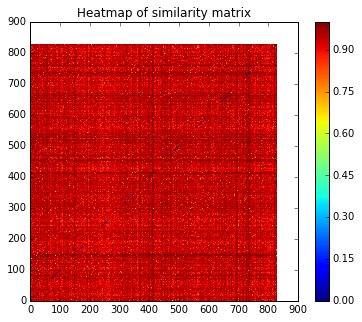

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.pcolor(cosine_sim_results)
ax.set_title('Heatmap of similarity matrix')
plt.colorbar()

In [46]:
import heapq
neighbors = np.zeros((cosine_sim_results.shape[0],10))
count=0
for row in cosine_sim_results[:50,:]:
    # get the indices that would sort the row
    # replace values with the index
    # sort the rows
    closest10 = heapq.nsmallest(10, range(len(row)), row.take)
    neighbors[count] = closest10
    count+=1
print neighbors.shape
print neighbors[3]

(15410, 10)
[  3.00000000e+00   5.81000000e+03   3.69000000e+03   9.03600000e+03
   3.51100000e+03   1.42450000e+04   5.55800000e+03   3.17300000e+03
   7.40500000e+03   8.22300000e+03]


## Function to get similar users for any input user

In [62]:
def printNeighbors(firstUser):
    for each in neighbors[firstUser,0:8]:
        print "\nUser: ", each, "Cosine: ", cosine_sim_results[firstUser,each]
        print data_combined['reviewText'][int(each)]
        print "--------"
printNeighbors(12)


User:  12.0 Cosine:  2.22044604925e-16
While I enjoyed reading this one, I found myself skipping parts that seemed "wordy" and drawn out. There's an excellent story to it but one has to dig for it. The mystery of what was happening next kept me up reading into the night.  This has to be the best of Ms. Livingston's, yet. This is by far my favorite!! The story is so well written that one forgets the time period it depicts. I'm loving Mrs. Hill 's style and don't want to put it down.
--------

User:  6435.0 Cosine:  0.690377863938
Grace Livingston Hill always has a great story line. She was a wonderful author. I love the way she brings in the need for faith in  our lives. what a great story, Grace Livingston Hill is my heroine. I love the simple, clean story-line. As I read Ms. Livingston's books I think of all the women over the years that have also enjoyed her books. She was so cool!!!!
--------

User:  6178.0 Cosine:  0.717435358027
I thought at first that this would be a real Christ

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


## Function to search reviews for user that has a specific keyword, and get similar reviews for that user

In [63]:
def searchReviews(search_term): 
    index = all_feature_names.index(search_term)
    #except ValueError: print("Not found in reviews")
    first_user_with_term = np.argmax(x[:,index]>0)
    print first_user_with_term
    if first_user_with_term<50:
        printNeighbors(first_user_with_term)
    else: print("We haven't calculated that one yet")

In [64]:
searchReviews('predictable')

24

User:  24.0 Cosine:  1.11022302463e-16
I loved the suspense and unpredictable story. It kept me on my toes thinking it couldn't be that easy or simple but it was. If only life were....... (laughing) A bit predictable having read a number of Elizabeth's booksDisappointed I was missing a good number of pages (electronically on kindle) but still couldn't put the book down! Good read! I got lost in this book. But in a good way. It's filled with uncertainty and yet, hope.I wish there was an epilogue. But I guess we could use our imaginations.  In all it was a wonderful read!
--------

User:  4837.0 Cosine:  0.746106929822
The plot had some predictable events but also some unpredictable events.  I would recommend this book to young readers.  I hope the next book continues with the same people
--------

User:  11388.0 Cosine:  0.755592342637
This book was very  Good, it had me on my toes the whole time.I couldn't stop turning the pages. It's a must read.
--------

User:  5976.0 Cosine:  0

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


### Future work: For each item, get the average of ratings among N similar users (only using those who have rated the item)

### Future work: Make recommendations for each user-item pair.